In [1]:
import pandas as pd
import numpy as np
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
df=pd.read_csv("sfix_aii_take_home_ratings/take_home_ss_ratings.csv")

In [4]:
df1=df[df['quiz_type']=='random']

In [5]:
df2=df[df['quiz_type']=='personalized']

In [6]:
df1.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
0,0,random,0,0,45,1
1,0,random,0,1,734,1
2,0,random,0,2,4145,1
3,0,random,0,3,3231,0
4,0,random,0,4,361,1


In [7]:
df2.head()

,user_id,quiz_type,quiz_number,question_number,item_id,rating
50,2,personalized,0,0,4373,0
51,2,personalized,0,1,3006,1
52,2,personalized,0,2,3866,0
53,2,personalized,0,3,939,1
54,2,personalized,0,4,863,1


In [8]:
df1_mod=df1.groupby(['user_id','item_id']).agg(rating=('rating','sum'))
df2_mod=df2.groupby(['user_id','item_id']).agg(rating=('rating','sum'))


In [9]:
df1_mod
df2_mod

rating
user_id item_id        
0       45            1
        65            0
        96            1
        253           1
        256           0
...                 ...
19999   4558          1
        4647          0
        4766          1
        4776          1
        4957          1

[774061 rows x 1 columns]

rating
user_id item_id        
2       53            1
        863           1
        939           1
        2336          0
        3006          1
...                 ...
19999   3388          1
        4274          1
        4304          1
        4607          1
        4896          1

[334151 rows x 1 columns]

In [10]:
df1_new=df1[['user_id','item_id','rating']]
df2_new=df1[['user_id','item_id','rating']]

In [11]:
df1_new

,user_id,item_id,rating
0,0,45,1
1,0,734,1
2,0,4145,1
3,0,3231,0
4,0,361,1
...,...,...,...
1116365,19999,3324,0
1116366,19999,3681,0
1116367,19999,2731,0
1116368,19999,1442,0


In [12]:
df2_new

,user_id,item_id,rating
0,0,45,1
1,0,734,1
2,0,4145,1
3,0,3231,0
4,0,361,1
...,...,...,...
1116365,19999,3324,0
1116366,19999,3681,0
1116367,19999,2731,0
1116368,19999,1442,0


In [13]:
df1_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779920 entries, 0 to 1116369
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  779920 non-null  int64
 1   item_id  779920 non-null  int64
 2   rating   779920 non-null  int64
dtypes: int64(3)
memory usage: 39.9 MB


In [14]:
#Five point summary 

df1_new.describe()['rating'].T

count    779920.000000
mean          0.503293
std           0.499989
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64

 ### Handling Missing values

In [15]:
df1_new.isnull().sum()

user_id    0
item_id    0
rating     0
dtype: int64

In [16]:
df2_new.isnull().sum()

user_id    0
item_id    0
rating     0
dtype: int64

### Ratings

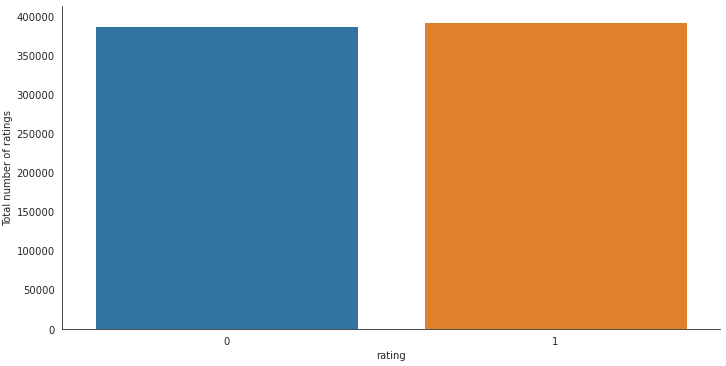

In [17]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df1_new, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

#### 0 and 1 ratings are distributed almost equal in the data set

### Unique Users and products

In [18]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df1_new.shape[0])
print("Total No of Users   :", len(np.unique(df1_new.user_id)))
print("Total No of products  :", len(np.unique(df1_new.item_id)))

Total data 
--------------------------------------------------

Total no of ratings : 779920
Total No of Users   : 18304
Total No of products  : 5000


### Analyzing the rating

In [19]:
no_of_rated_products_per_user = df1_new.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

user_id
13613    800
11786    510
15044    450
18810    410
6273     400
Name: rating, dtype: int64

In [20]:
no_of_rated_products_per_user.describe()

count    18304.000000
mean        42.609266
std         43.146337
min         10.000000
25%         10.000000
50%         30.000000
75%         60.000000
max        800.000000
Name: rating, dtype: float64

In [21]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

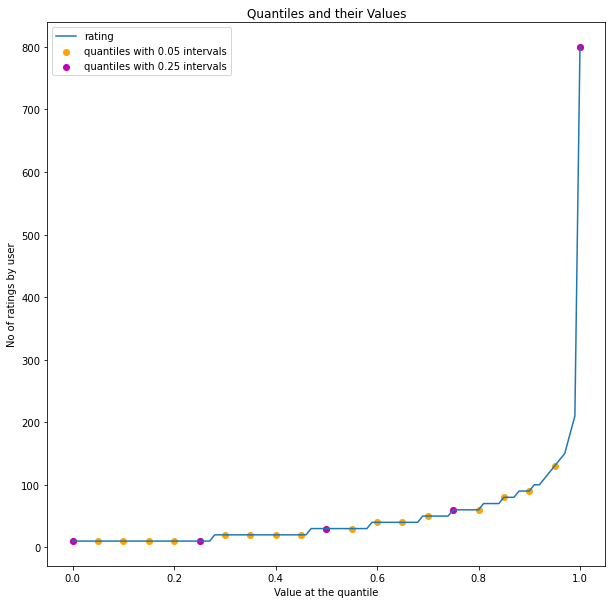

In [22]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [23]:
print('\n No of rated product more than 300 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 300)) )


 No of rated product more than 300 per user : 34



## Collaberative filtering (Item-Item recommedation)

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [24]:
#python -m pip install surprise

In [25]:
#pip install surprise

In [26]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [27]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df1_new,reader)

In [28]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [29]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
test_pred = algo.test(testset)

In [31]:
test_pred


[Prediction(uid=745, iid=2241, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=19030, iid=545, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=7825, iid=1938, r_ui=1.0, est=1, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=16164, iid=4707, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=13380, iid=2638, r_ui=0.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=8735, iid=50, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=14551, iid=833, r_ui=0.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=502, iid=1627, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=9666, iid=4928, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=4788, iid=4216, r_ui=1.0, est=1, details={'actual_k': 5, 'was_impossible': False}),
 P

In [32]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.7074


0.7074396949175488

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [33]:
new_df1=df1_new.head(10000)
ratings_matrix = new_df1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_matrix.head()

item_id,0,1,2,3,4,6,7,8,9,10,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [34]:
ratings_matrix.shape

(255, 4310)

In [35]:
X = ratings_matrix.T
X.head()

user_id,0,1,2,3,4,5,6,8,9,10,...,283,284,285,286,287,288,289,290,291,292
item_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X.shape

(4310, 255)

Unique products in subset of data

In [37]:
X1 = X

In [38]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(4310, 10)

In [39]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(4310, 4310)

In [40]:
X.index[4309]

4999

Index # of product ID purchased by customer

In [41]:
i = 4999

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

4309

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [42]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(4310,)

Recommending top 25 highly correlated products in sequence

In [43]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

[30,
 86,
 121,
 138,
 151,
 210,
 223,
 228,
 251,
 261,
 271,
 334,
 338,
 343,
 427,
 439,
 485,
 517,
 544,
 566,
 571,
 573,
 741,
 746]